## **0. Librerías y funciones**

In [4]:
!poetry install



[tool.poetry] section not found in c:/Users/richa/OneDrive/Escritorio/proyecto m6/tdsp_template/pyproject.toml


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# Configurar tamaño de figuras
plt.rcParams['figure.figsize'] = (12, 8)
import os



def one_hot_encode(df, drop_cols=None):
    """
    Aplica one-hot encoding a las variables categóricas de un DataFrame,
    mantiene las variables numéricas y permite eliminar columnas específicas.

    Parámetros:
    ----------
    df : pd.DataFrame
        El DataFrame de entrada.
    drop_cols : list, opcional
        Lista de nombres de columnas a eliminar antes del procesamiento.

    Retorna:
    -------
    pd.DataFrame
        Un nuevo DataFrame con variables categóricas codificadas y numéricas intactas.
    """

    # Eliminar columnas si se especifican
    if drop_cols is not None:
        df = df.drop(columns=drop_cols)

    # Separar variables categóricas y numéricas
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    num_cols = df.select_dtypes(exclude=['object', 'category']).columns

    # One-hot encoding para las categóricas
    df_cat = pd.get_dummies(df[cat_cols], drop_first=True).astype(int)

    # Concatenar con las numéricas
    df_final = pd.concat([df[num_cols], df_cat], axis=1)

    return df_final


def convertir_categoricas_a_numericas(df, umbral_unicos=10, umbral_numerico=0.95):
    """
    Convierte columnas categóricas con muchos valores únicos a tipo float
    si un porcentaje suficiente de sus valores son numéricos.

    Parámetros:
    -----------
    df : pd.DataFrame
        El DataFrame de entrada.

    umbral_unicos : int
        Número mínimo de valores únicos en la columna categórica para considerarla candidata.

    umbral_numerico : float
        Proporción mínima (entre 0 y 1) de valores numéricos necesarios para convertir a float.

    Retorna:
    --------
    pd.DataFrame
        El DataFrame con las columnas convertidas si corresponde.
    """

    df_mod = df.copy()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns

    for col in cat_cols:
        num_unicos = df[col].nunique()
        if num_unicos > umbral_unicos:
            # Intentar convertir valores a float de forma segura
            serie = df[col].astype(str)
            es_numerico = serie.apply(lambda x: x.replace(',', '.').replace(' ', '').replace('$', '')).str.match(r'^-?\d+(\.\d+)?$')
            proporcion_numericos = es_numerico.mean()

            if proporcion_numericos >= umbral_numerico:
                print(f"Convirtiendo columna '{col}' a float ({proporcion_numericos:.2%} valores numéricos)...")
                df_mod[col] = serie.apply(lambda x: x.replace(',', '.').replace(' ', '').replace('$', ''))
                df_mod[col] = pd.to_numeric(df_mod[col], errors='coerce')

    return df_mod




## **1. Descargar dataset y vista previa**

In [15]:
# Cargar datos
df = pd.read_csv('../../src/database/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = convertir_categoricas_a_numericas(df)
df.head()

Convirtiendo columna 'TotalCharges' a float (99.84% valores numéricos)...


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### **2 One hot encodding**

In [16]:
df = one_hot_encode(df, drop_cols=['Churn','customerID'])

### **1.2 Valores faltantes**

No se encuentran valores faltantes para ninguna variable

In [17]:
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Columna': df.columns,
    'Valores_Faltantes': missing_data,
    'Porcentaje': missing_percent
}).sort_values('Valores_Faltantes', ascending=False)

print(missing_df)

                                                                     Columna  \
TotalCharges                                                    TotalCharges   
SeniorCitizen                                                  SeniorCitizen   
tenure                                                                tenure   
MonthlyCharges                                                MonthlyCharges   
gender_Male                                                      gender_Male   
Partner_Yes                                                      Partner_Yes   
Dependents_Yes                                                Dependents_Yes   
PhoneService_Yes                                            PhoneService_Yes   
MultipleLines_No phone service                MultipleLines_No phone service   
MultipleLines_Yes                                          MultipleLines_Yes   
InternetService_Fiber optic                      InternetService_Fiber optic   
InternetService_No                      

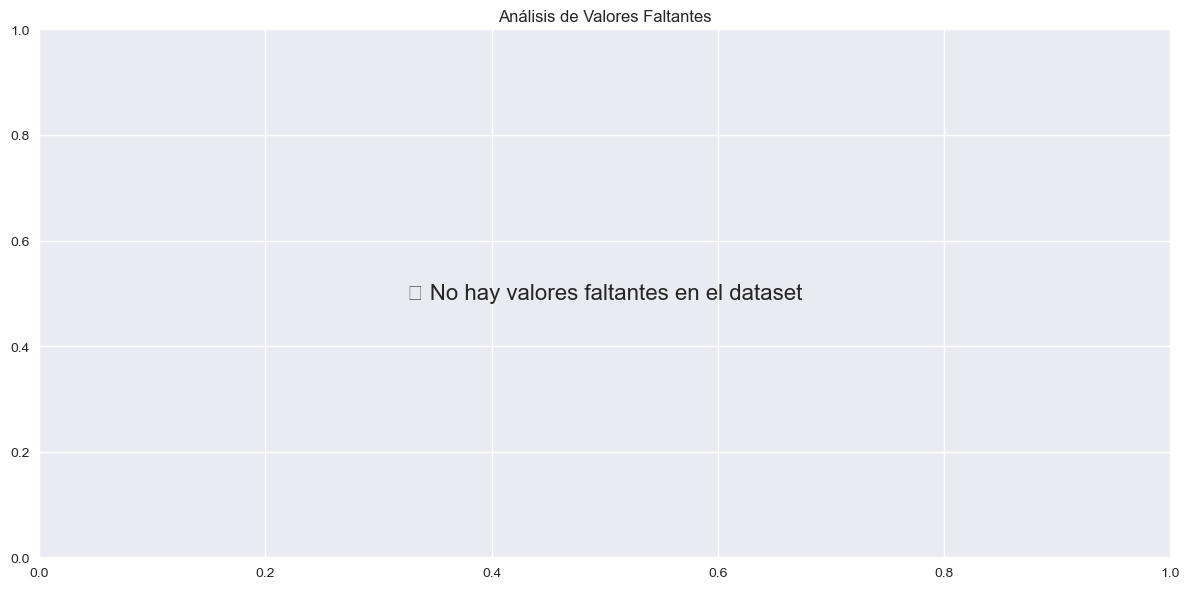

In [8]:
# Visualizar valores faltantes
fig, ax = plt.subplots(figsize=(12, 6))
missing_df_plot = missing_df[missing_df['Valores_Faltantes'] > 0]

if not missing_df_plot.empty:
    sns.barplot(data=missing_df_plot, x='Porcentaje', y='Columna', ax=ax)
    ax.set_title('Porcentaje de Valores Faltantes por Columna')
    ax.set_xlabel('Porcentaje de Valores Faltantes')
else:
    ax.text(0.5, 0.5, '✅ No hay valores faltantes en el dataset', 
            ha='center', va='center', transform=ax.transAxes, fontsize=16)
    ax.set_title('Análisis de Valores Faltantes')

plt.tight_layout()
plt.show()

### **1.3 Valores duplicados**

No se encuentran registros duplicados

In [9]:
duplicados = df.duplicated().sum()
print(f"Filas duplicadas: {duplicados}")
print(f"Porcentaje de duplicados: {(duplicados/len(df))*100:.2f}%")

Filas duplicadas: 0
Porcentaje de duplicados: 0.00%


In [10]:
tipos_datos = df.dtypes.value_counts()
print("Distribución de tipos de datos:")
print(tipos_datos)

Distribución de tipos de datos:
object     18
int64       2
float64     1
Name: count, dtype: int64


In [11]:
for tipo in df.dtypes.unique():
    columnas = df.select_dtypes(include=[tipo]).columns.tolist()
    print(f"{tipo}: {columnas}")


object: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'TotalCharges', 'Churn']
int64: ['SeniorCitizen', 'tenure']
float64: ['MonthlyCharges']


## **2. Exploración de Datos**

### **2.1 Exploracion del target**

La categoria mayoritaria para churn es No con un 73.5% de los datos. No se considera que halla un gran desbalanceo en la variable churn.

In [12]:
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print("Distribución de Churn:")
for valor, conteo in churn_counts.items():
    pct = churn_pct[valor]
    print(f"{valor}: {conteo} ({pct:.1f}%)")

Distribución de Churn:
No: 5174 (73.5%)
Yes: 1869 (26.5%)


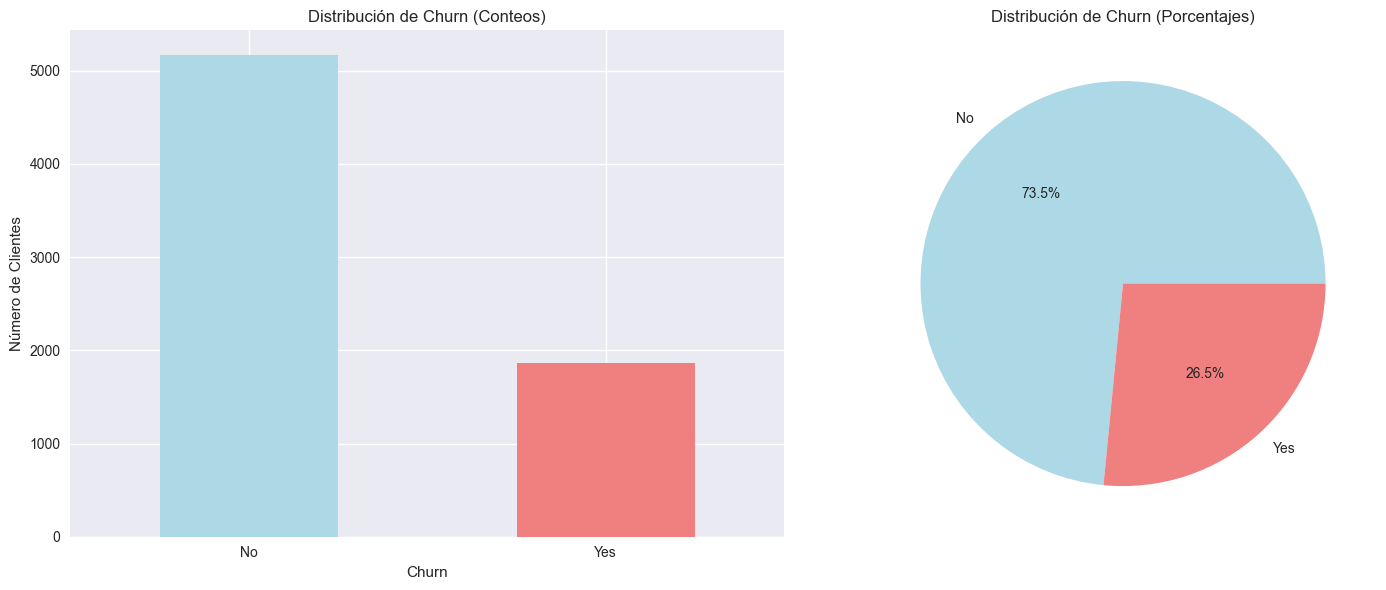

In [ ]:
# Visualización de la distribución de Churn
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
churn_counts.plot(kind='bar', ax=ax1, color=['lightblue', 'lightcoral'])
ax1.set_title('Distribución de Churn (Conteos)')
ax1.set_xlabel('Churn')
ax1.set_ylabel('Número de Clientes')
ax1.set_xticklabels(churn_counts.index, rotation=0)

# Gráfico de pastel
ax2.pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', 
        colors=['lightblue', 'lightcoral'])
ax2.set_title('Distribución de Churn (Porcentajes)')

plt.tight_layout()
plt.show()

### **2.2 Variables numéricas**

La variable TotalCharges puede convertirse en un valor numérico, sin embargo, hay valores faltantes que deben ser manejados. Las variables Tenure y MonthlyCharges están altamente correlacionadas (correlación de 0.83).

**1. SeniorCitizen**
Distribución: Altamente desequilibrada. La mayoría de los clientes no son personas mayores (SeniorCitizen = 0).

Media: 0.16 — solo un 16% de los clientes son personas mayores.

Mediana: 0 — refuerza que la mayoría no lo son.

Implicación: Puede ser una variable útil si ser senior afecta la probabilidad de churn, pero hay desbalance.

**2. tenure (tiempo de permanencia del cliente)**
Distribución: Multimodal, pero con mayor concentración en valores bajos y altos.

Media: 32.37

Mediana: 29.0

Implicación:

Hay muchos clientes nuevos (tenure bajo) y varios clientes antiguos.

Podrías investigar si los clientes con menor tenure tienen más probabilidad de churn.

Dado que media > mediana, la distribución tiene una ligera cola derecha (asimetría positiva).

**3. MonthlyCharges**
Distribución: Sesgada hacia la izquierda (asimetría negativa).

Media: 64.76

Mediana: 70.35

Implicación:

Hay muchos clientes con cargos bajos (~20), pero también una gran parte con cargos más altos.

La mediana mayor a la media sugiere presencia de un grupo significativo con cargos bajos (posiblemente planes básicos o promociones).

Podría analizarse si los clientes con cargos bajos o altos tienden más al churn.

**4. TotalCharges**
Distribución: Altamente sesgada hacia la derecha (asimetría positiva).

Media: 2283.30

Mediana: 1397.47

Implicación:

Hay muchos clientes con cargos totales bajos (posiblemente recién adquiridos).

Como era de esperarse, TotalCharges está relacionado con tenure.

Esta variable también sugiere una distribución de clientes en distintas fases del ciclo de vida.

In [35]:
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"📊 VARIABLES NUMÉRICAS: {columnas_numericas}")

# Convertir TotalCharges a numérico si es necesario
if 'TotalCharges' in df.columns:
    # Verificar si TotalCharges es string
    if df['TotalCharges'].dtype == 'object':
        print("🔄 Convirtiendo TotalCharges a numérico...")
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        print(f"Valores no convertibles (NaN): {df['TotalCharges'].isnull().sum()}")

📊 VARIABLES NUMÉRICAS: ['SeniorCitizen', 'tenure', 'MonthlyCharges']
🔄 Convirtiendo TotalCharges a numérico...
Valores no convertibles (NaN): 11


In [36]:
# Actualizar lista de columnas numéricas
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"📊 VARIABLES NUMÉRICAS ACTUALIZADAS: {columnas_numericas}")

📊 VARIABLES NUMÉRICAS ACTUALIZADAS: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


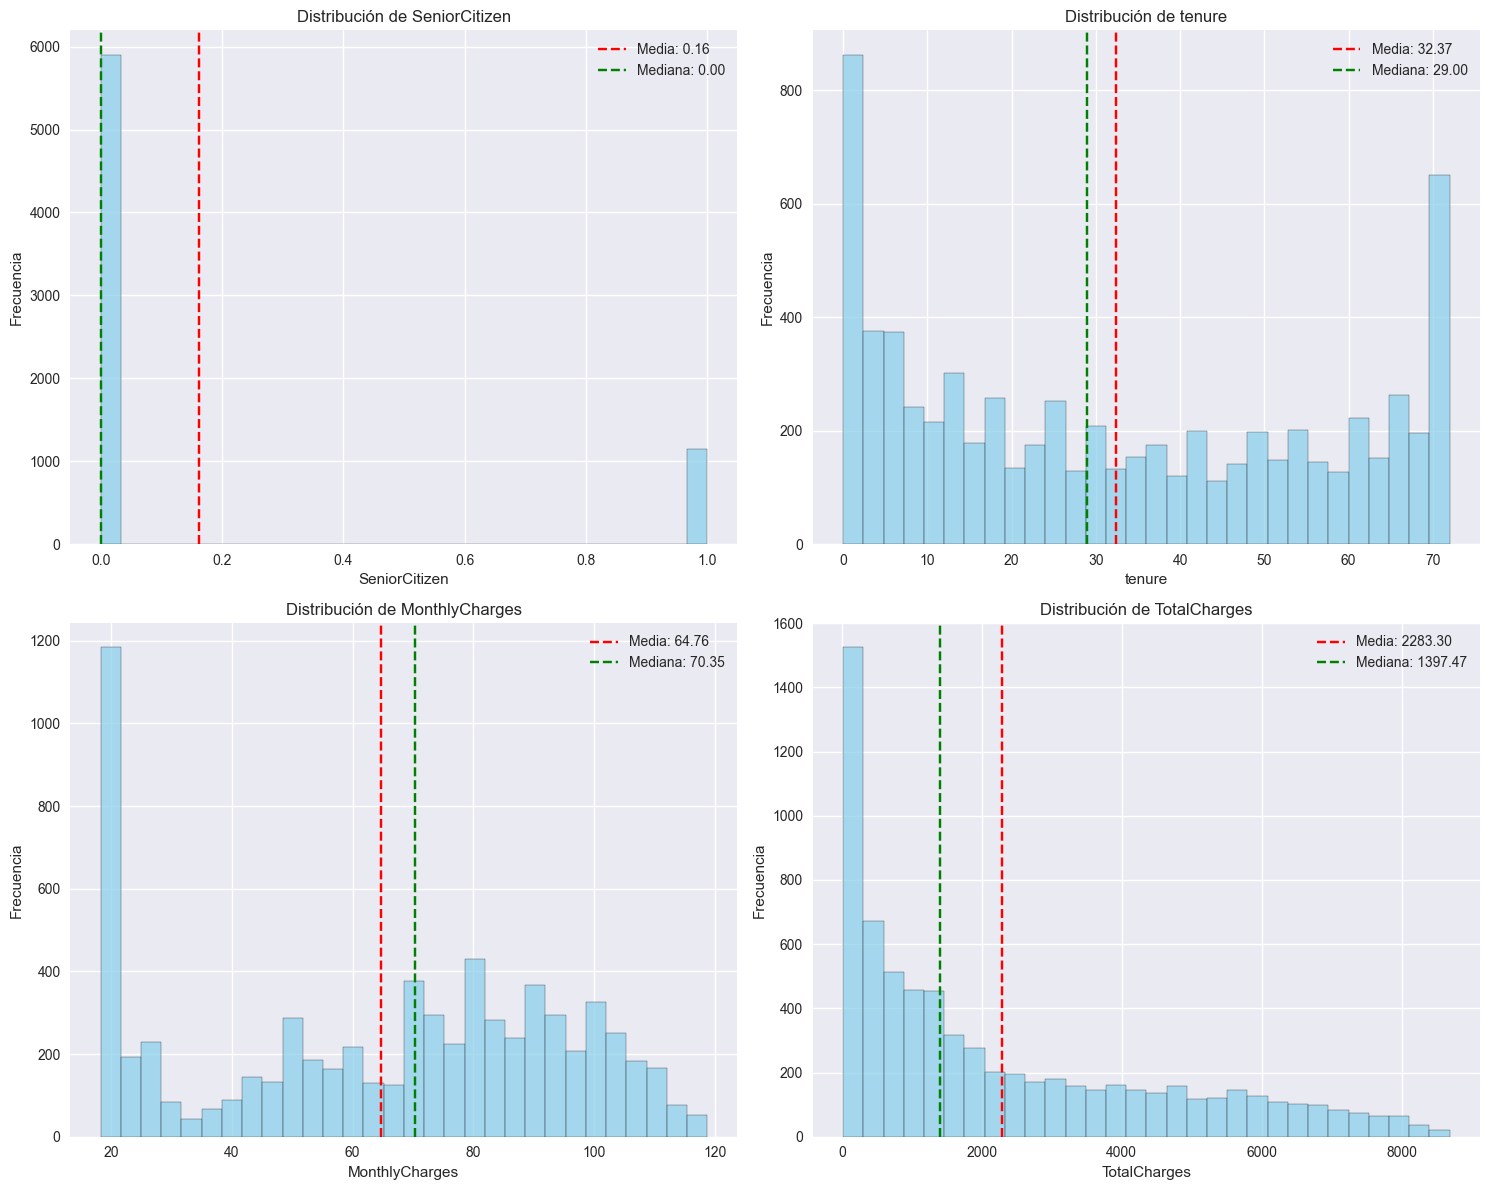

In [37]:
# Distribución de variables numéricas
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(columnas_numericas[:4]):
    if i < len(axes):
        ax = axes[i]
        
        # Histograma
        df[col].hist(bins=30, ax=ax, alpha=0.7, color='skyblue', edgecolor='black')
        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        
        # Estadísticas
        media = df[col].mean()
        mediana = df[col].median()
        ax.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
        ax.axvline(mediana, color='green', linestyle='--', label=f'Mediana: {mediana:.2f}')
        ax.legend()

plt.tight_layout()
plt.show()


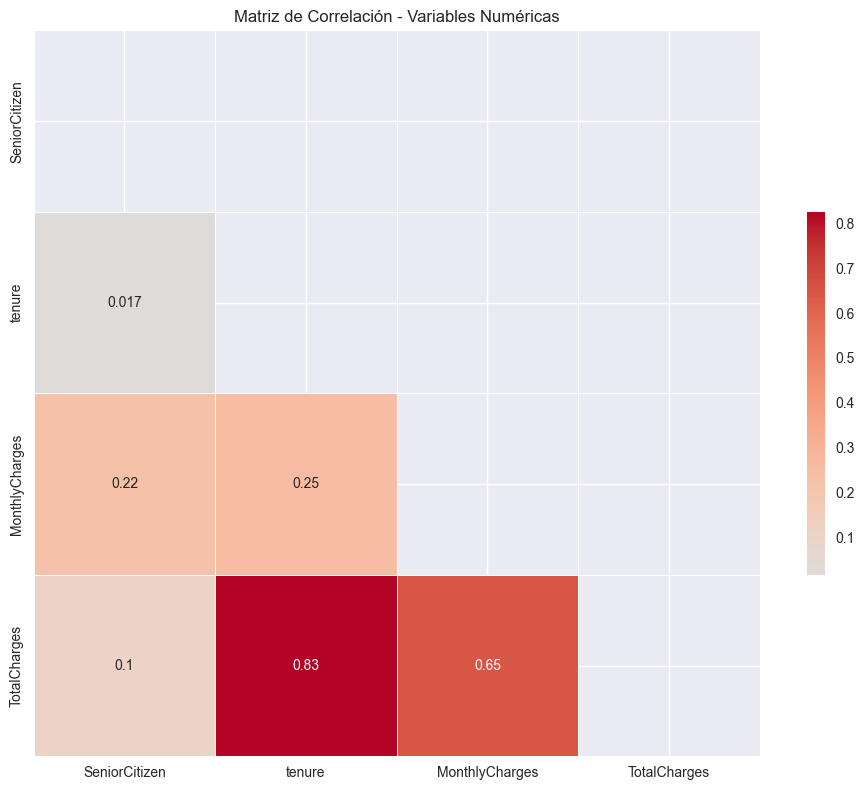

In [ ]:
corr_matrix = df[columnas_numericas].corr()
# Visualizar matriz de correlación
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

### **2.3 Variables categóricas**

Todas las variables categóricas son tienen como máximo 4 valores únicos. No presentan desbalanceo a excepción de la variable Churn que tiene un desbalanceo del 73% y de la variable PhoneService que tiene un desbalanceo del 85%.

In [39]:
# Identificar variables categóricas
columnas_categoricas = df.select_dtypes(include=['object']).columns.tolist()
print(f"📊 VARIABLES CATEGÓRICAS: {columnas_categoricas}")

📊 VARIABLES CATEGÓRICAS: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [40]:
for col in columnas_categoricas:
    unique_values = df[col].nunique()
    print(f"{col}: {unique_values} valores únicos")
    if unique_values <= 10:
        print(f"  Valores: {df[col].unique()}")
    print()


customerID: 7043 valores únicos

gender: 2 valores únicos
  Valores: ['Female' 'Male']

Partner: 2 valores únicos
  Valores: ['Yes' 'No']

Dependents: 2 valores únicos
  Valores: ['No' 'Yes']

PhoneService: 2 valores únicos
  Valores: ['No' 'Yes']

MultipleLines: 3 valores únicos
  Valores: ['No phone service' 'No' 'Yes']

InternetService: 3 valores únicos
  Valores: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: 3 valores únicos
  Valores: ['No' 'Yes' 'No internet service']

OnlineBackup: 3 valores únicos
  Valores: ['Yes' 'No' 'No internet service']

DeviceProtection: 3 valores únicos
  Valores: ['No' 'Yes' 'No internet service']

TechSupport: 3 valores únicos
  Valores: ['No' 'Yes' 'No internet service']

StreamingTV: 3 valores únicos
  Valores: ['No' 'Yes' 'No internet service']

StreamingMovies: 3 valores únicos
  Valores: ['No' 'Yes' 'No internet service']

Contract: 3 valores únicos
  Valores: ['Month-to-month' 'One year' 'Two year']

PaperlessBilling: 2 valores únicos
  Valores: [

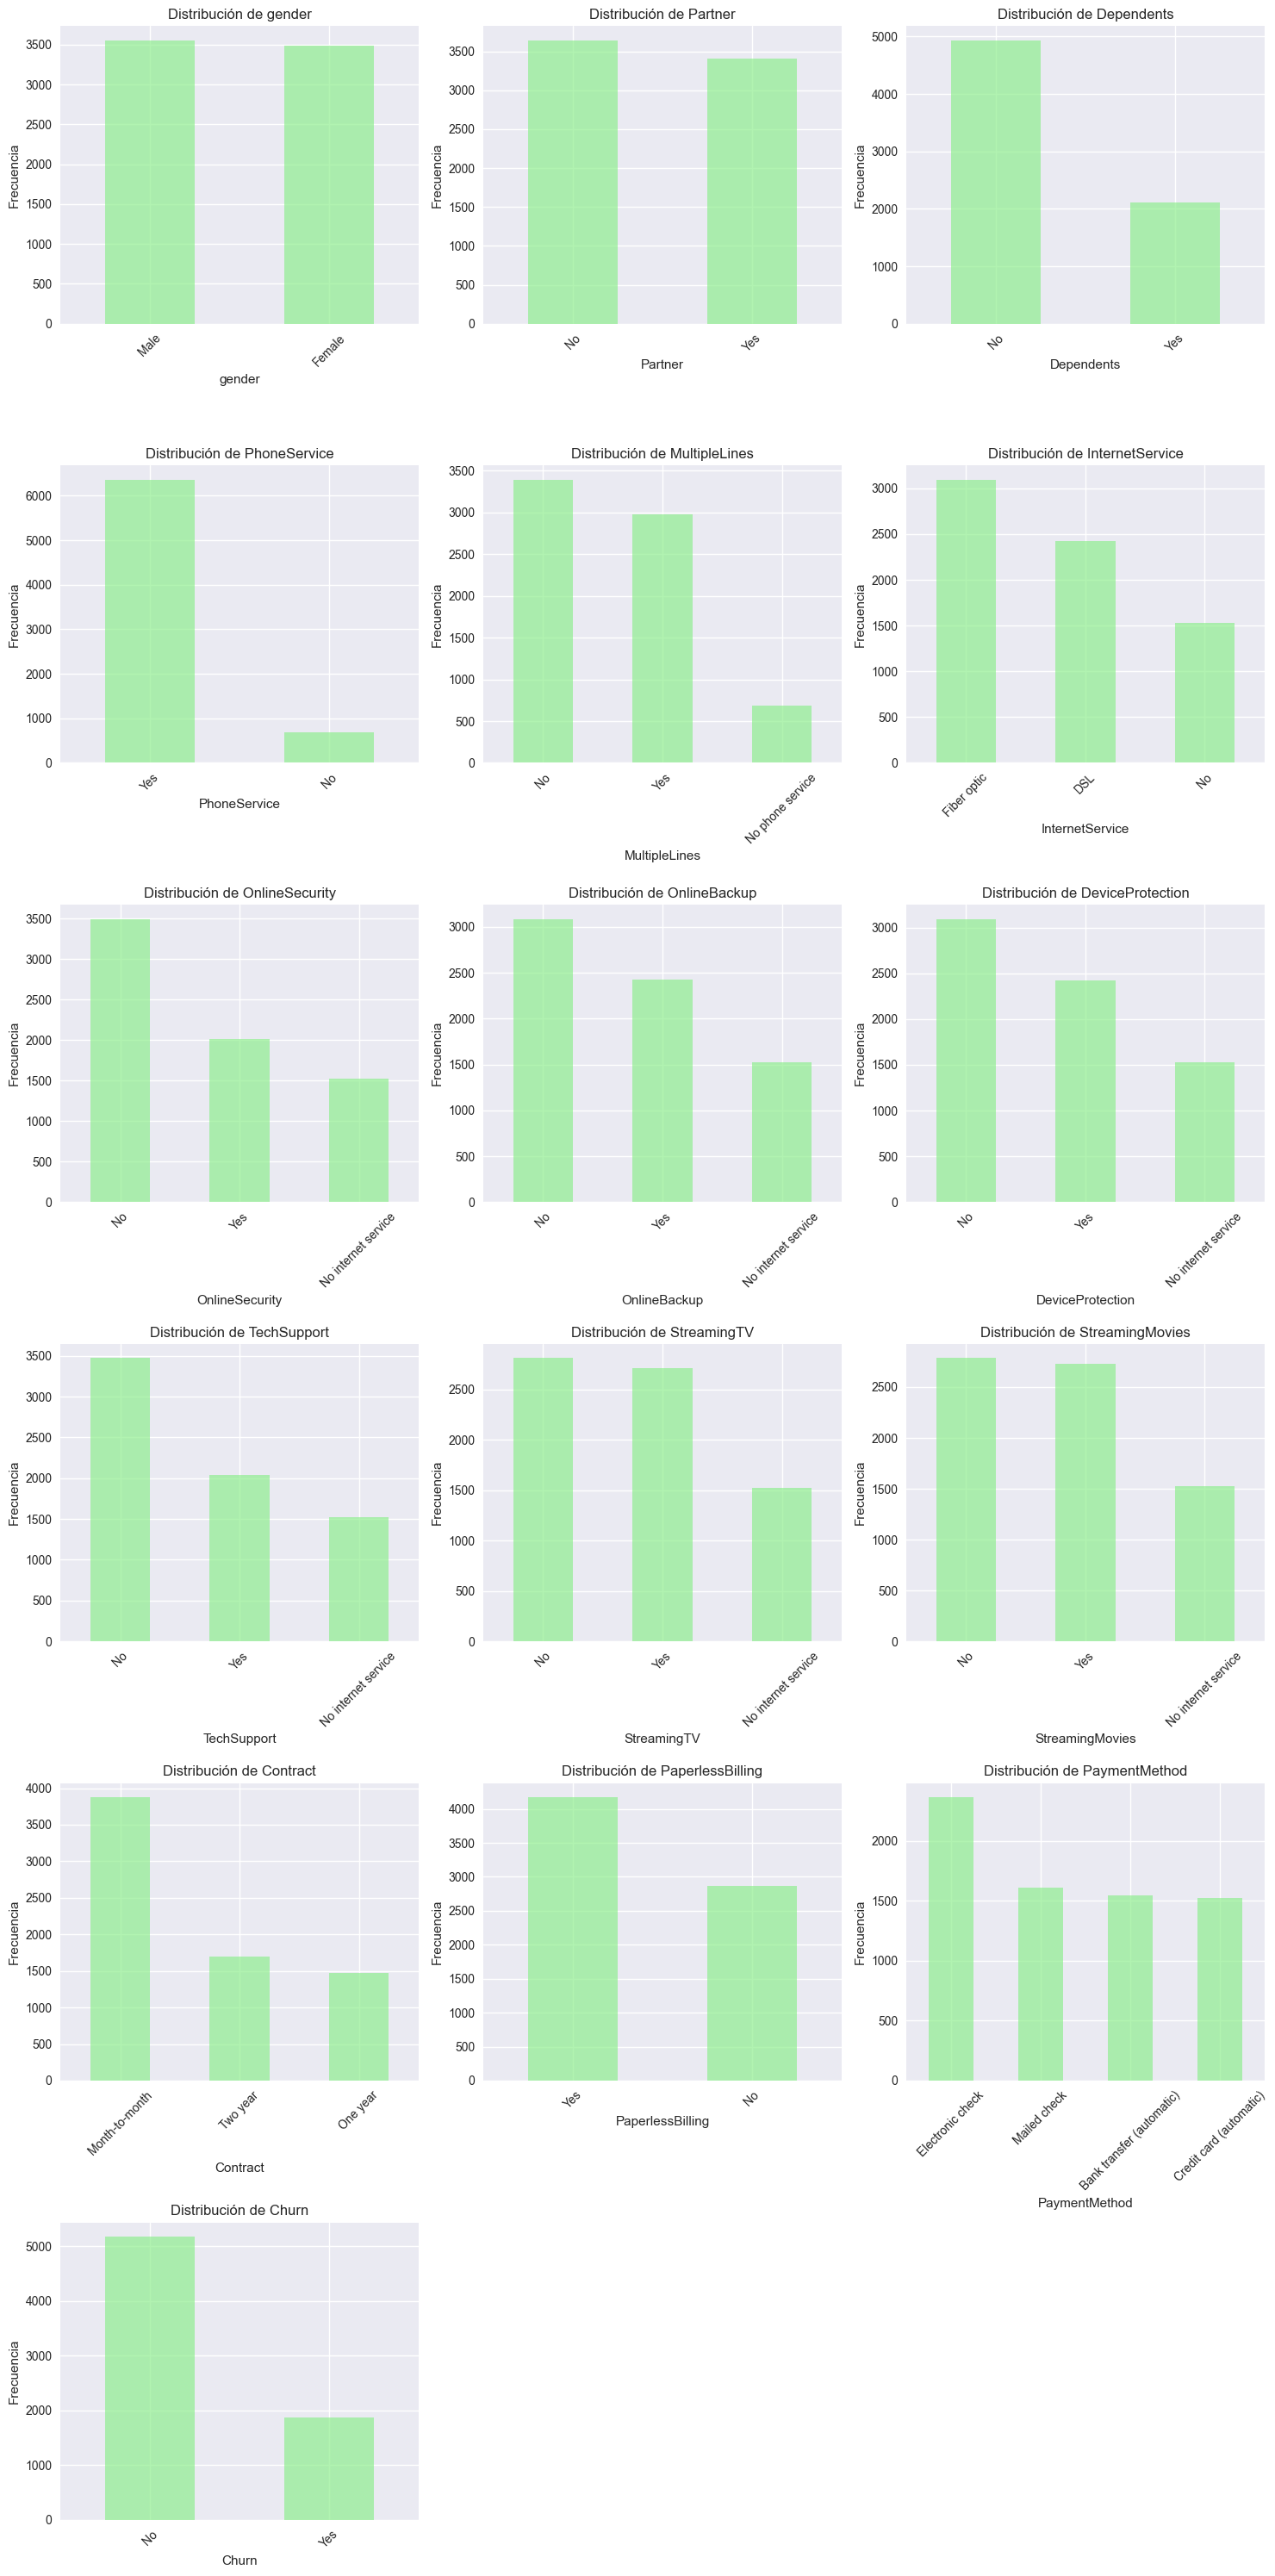

In [41]:
columnas_cat_viz = [col for col in columnas_categoricas if col != 'customerID']

# Calcular número de subplots necesarios
n_cols = min(3, len(columnas_cat_viz))
n_rows = (len(columnas_cat_viz) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for i, col in enumerate(columnas_cat_viz):
    if i < len(axes):
        ax = axes[i]
        
        # Contar valores
        value_counts = df[col].value_counts()
        
        # Gráfico de barras
        value_counts.plot(kind='bar', ax=ax, color='lightgreen', alpha=0.7)
        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)

# Ocultar ejes vacíos
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## **3. Relación entre variables**

### **3.1 Relación variables explicativas categóricas con la variable objetivo**

El análisis de las variables categóricas en relación con el churn revela varios patrones importantes. Variables como gender, PhoneService y MultipleLines no muestran diferencias significativas en la tasa de abandono, por lo que parecen tener poca capacidad predictiva. En contraste, tener pareja (Partner) o dependientes (Dependents) se asocia con una menor tasa de churn, lo que sugiere que clientes con responsabilidades familiares podrían tener mayor estabilidad en el servicio. El tipo de contrato es uno de los factores más determinantes: los contratos mensuales presentan una tasa de abandono muy superior (~43%) frente a los contratos anuales o bienales, donde el churn es inferior al 10%, lo que refleja un mayor compromiso por parte de los clientes con contratos más largos. En cuanto al método de pago, los clientes que usan transferencias bancarias o tarjetas de crédito automáticas muestran una menor tasa de churn, mientras que quienes pagan por cheque electrónico tienen una tasa mucho más alta (~45%), posiblemente indicando menor fidelización. Tener servicios como OnlineSecurity, TechSupport, DeviceProtection y OnlineBackup también se relaciona con una menor propensión al abandono, sugiriendo que los servicios complementarios generan una mayor retención. Por el contrario, clientes con InternetService de fibra óptica y PaperlessBilling presentan tasas de churn por encima del promedio, lo que podría estar vinculado con un perfil más volátil o una mayor exposición a la competencia. Finalmente, los clientes que no contratan servicios de entretenimiento como StreamingTV y StreamingMovies también muestran una tasa mayor de abandono, posiblemente por menor integración con el ecosistema del proveedor. En conjunto, estos hallazgos permiten identificar perfiles de riesgo y factores clave para estrategias de retención.




gender:
  Female: 26.9% churn
  Male: 26.2% churn

Partner:
  No: 33.0% churn
  Yes: 19.7% churn

Dependents:
  No: 31.3% churn
  Yes: 15.5% churn

PhoneService:
  No: 24.9% churn
  Yes: 26.7% churn

MultipleLines:
  No: 25.0% churn
  No phone service: 24.9% churn
  Yes: 28.6% churn

InternetService:
  DSL: 19.0% churn
  Fiber optic: 41.9% churn
  No: 7.4% churn

OnlineSecurity:
  No: 41.8% churn
  No internet service: 7.4% churn
  Yes: 14.6% churn

OnlineBackup:
  No: 39.9% churn
  No internet service: 7.4% churn
  Yes: 21.5% churn

DeviceProtection:
  No: 39.1% churn
  No internet service: 7.4% churn
  Yes: 22.5% churn

TechSupport:
  No: 41.6% churn
  No internet service: 7.4% churn
  Yes: 15.2% churn

StreamingTV:
  No: 33.5% churn
  No internet service: 7.4% churn
  Yes: 30.1% churn

StreamingMovies:
  No: 33.7% churn
  No internet service: 7.4% churn
  Yes: 29.9% churn

Contract:
  Month-to-month: 42.7% churn
  One year: 11.3% churn
  Two year: 2.8% churn

PaperlessBilling:
  No

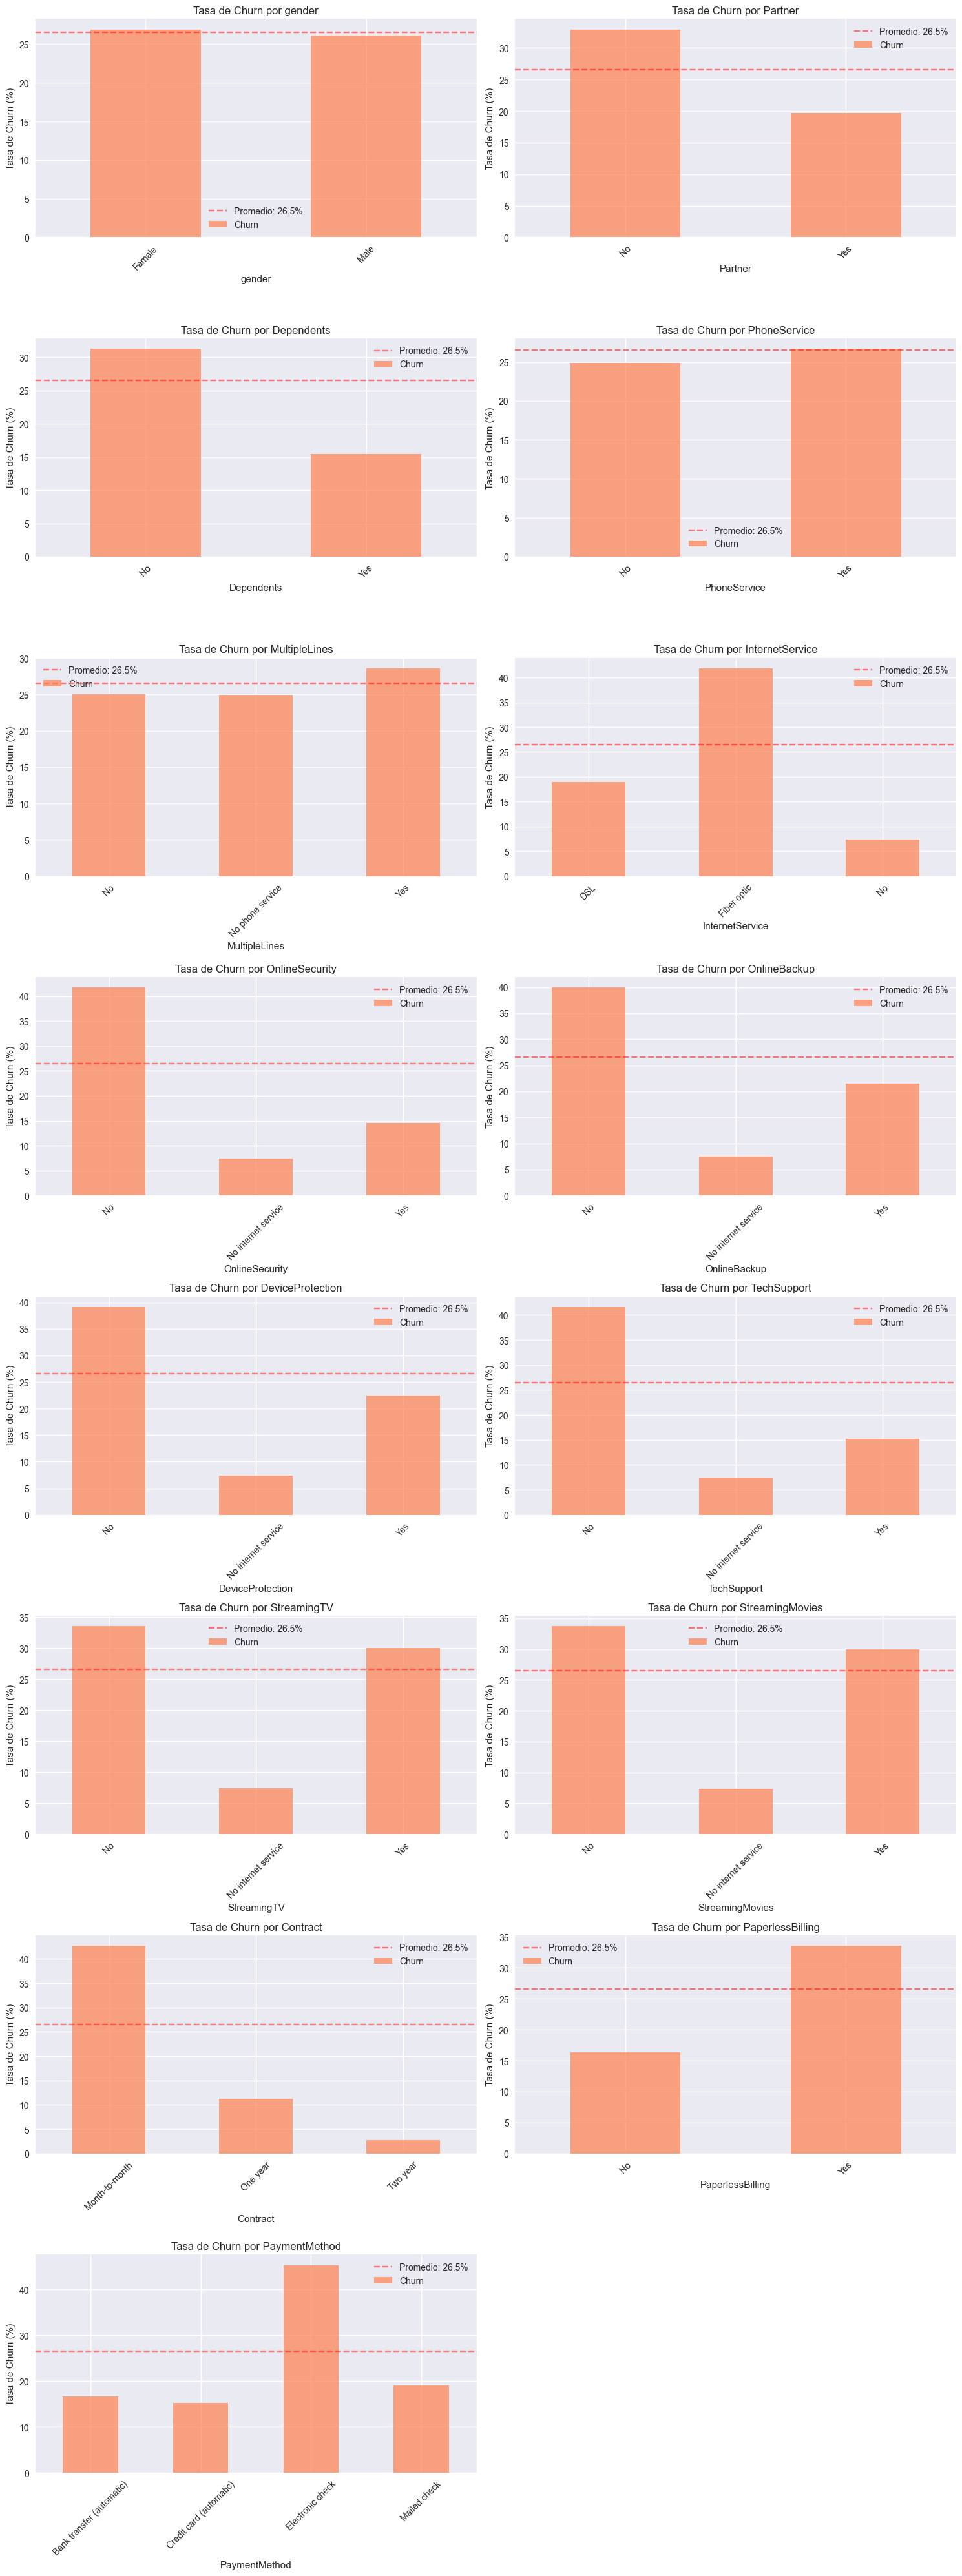

In [ ]:
# Excluir customerID y Churn
columnas_cat_analisis = [col for col in columnas_categoricas if col not in ['customerID', 'Churn']]

# Calcular tasas de churn por categoría
churn_rates = {}
for col in columnas_cat_analisis:
    rates = df.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    churn_rates[col] = rates
    print(f"\n{col}:")
    for categoria, rate in rates.items():
        print(f"  {categoria}: {rate:.1f}% churn")

# %%
# Visualización de tasas de churn por categorías
n_cols = 2
n_rows = (len(columnas_cat_analisis) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
if n_rows == 1:
    axes = [axes] if n_cols == 1 else axes
else:
    axes = axes.flatten()

for i, col in enumerate(columnas_cat_analisis):
    if i < len(axes):
        ax = axes[i]
        
        # Calcular tasas de churn
        rates = df.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
        
        # Gráfico de barras
        rates.plot(kind='bar', ax=ax, color='coral', alpha=0.7)
        ax.set_title(f'Tasa de Churn por {col}')
        ax.set_xlabel(col)
        ax.set_ylabel('Tasa de Churn (%)')
        ax.tick_params(axis='x', rotation=45)
        
        # Línea de referencia (tasa promedio)
        avg_churn = (df['Churn'] == 'Yes').mean() * 100
        ax.axhline(avg_churn, color='red', linestyle='--', alpha=0.5, 
                   label=f'Promedio: {avg_churn:.1f}%')
        ax.legend()

# Ocultar ejes vacíos
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **3.2 Relación entre variables numéricas y churn**

Los histogramas segmentados por churn muestran que las variables numéricas tienen una relación clara con la probabilidad de abandono. En el caso de SeniorCitizen, aunque la mayoría de los clientes no son adultos mayores, se observa que quienes sí lo son presentan una proporción más alta de churn, lo que sugiere que la edad podría influir en la decisión de abandonar el servicio. La variable tenure evidencia una relación inversa muy marcada: los clientes con poca antigüedad (especialmente entre 0 y 10 meses) concentran la mayor parte de los abandonos, mientras que aquellos con más tiempo en la compañía casi no desertan, lo que la convierte en un fuerte predictor. En cuanto a MonthlyCharges, se observa que los clientes con cargos mensuales altos tienen tasas más elevadas de churn, posiblemente por insatisfacción con el precio o servicios contratados, mientras que los clientes con tarifas bajas presentan menor abandono. Finalmente, TotalCharges, al estar relacionado con el tiempo y el valor del cliente, muestra que quienes han pagado menos (clientes recientes o de menor consumo) son mucho más propensos a irse, mientras que los clientes con cargos acumulados altos rara vez abandonan. En conjunto, estos hallazgos refuerzan que tenure y TotalCharges son fuertes indicadores de retención, mientras que MonthlyCharges y SeniorCitizen pueden ayudar a identificar perfiles de mayor riesgo de churn.


SeniorCitizen:
       count      mean  median       std
Churn                                   
No      5174  0.128721     0.0  0.334923
Yes     1869  0.254682     0.0  0.435799

tenure:
       count       mean  median        std
Churn                                     
No      5174  37.569965    38.0  24.113777
Yes     1869  17.979133    10.0  19.531123

MonthlyCharges:
       count       mean  median        std
Churn                                     
No      5174  61.265124  64.425  31.092648
Yes     1869  74.441332  79.650  24.666053

TotalCharges:
       count         mean   median          std
Churn                                          
No      5163  2555.344141  1683.60  2329.456984
Yes     1869  1531.796094   703.55  1890.822994


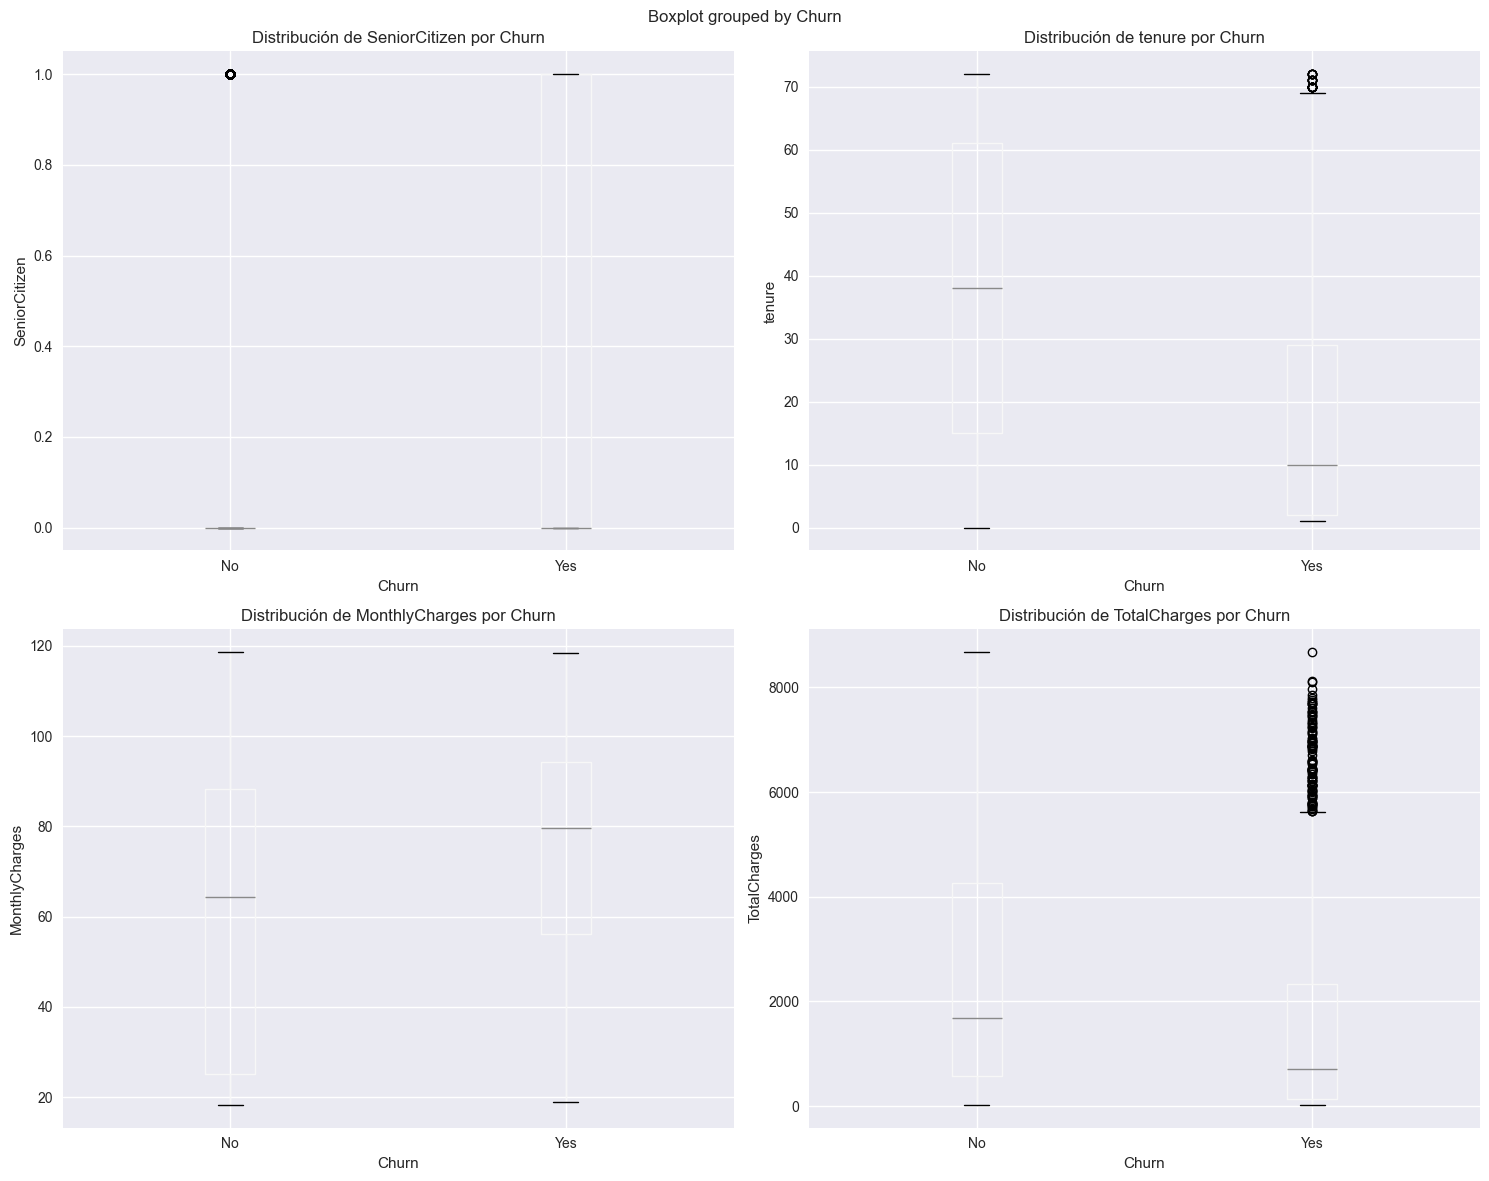

In [43]:
# Estadísticas por grupo de churn
for col in columnas_numericas:
    print(f"\n{col}:")
    stats_by_churn = df.groupby('Churn')[col].agg(['count', 'mean', 'median', 'std'])
    print(stats_by_churn)

# %%
# Visualización de distribuciones por churn
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(columnas_numericas[:4]):
    if i < len(axes):
        ax = axes[i]
        
        # Box plot
        df.boxplot(column=col, by='Churn', ax=ax)
        ax.set_title(f'Distribución de {col} por Churn')
        ax.set_xlabel('Churn')
        ax.set_ylabel(col)

plt.tight_layout()
plt.show()


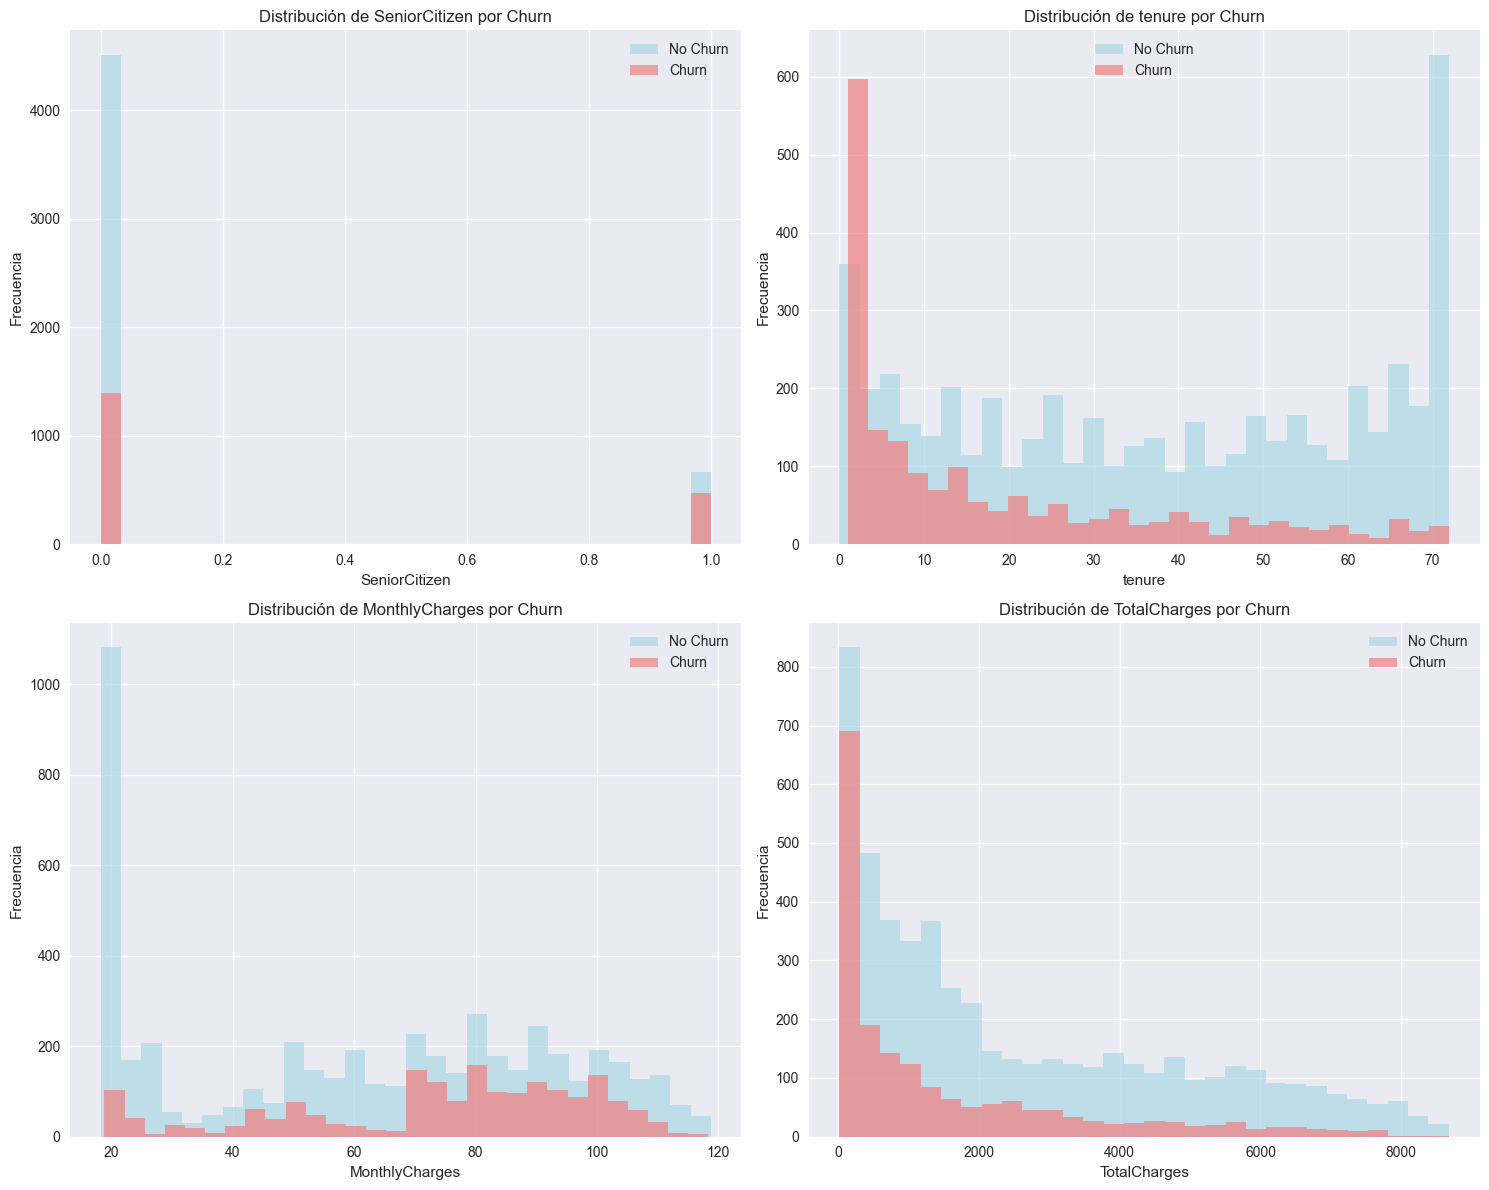

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(columnas_numericas[:4]):
    if i < len(axes):
        ax = axes[i]
        
        # Histogramas por grupo
        df[df['Churn'] == 'No'][col].hist(bins=30, alpha=0.7, label='No Churn', 
                                          color='lightblue', ax=ax)
        df[df['Churn'] == 'Yes'][col].hist(bins=30, alpha=0.7, label='Churn', 
                                           color='lightcoral', ax=ax)
        
        ax.set_title(f'Distribución de {col} por Churn')
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')
        ax.legend()

plt.tight_layout()
plt.show()